### Experiments setup

In [1]:
from sksurv.ensemble import RandomSurvivalForest
from pycox import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read text file into pandas DataFrame
data = pd.read_csv("BRCA_data_clinical_RNASeq_n_genes_20501.csv")

In [3]:
data.head()

,patientID,years_to_birth,vital_status,days_to_death,days_to_last_followup,tumor_tissue_site,pathologic_stage,gender,date_of_initial_pathologic_diagnosis,days_to_last_known_alive,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
0,TCGA-A1-A0SB,70.0,0,NaN,259.0,breast,stage 1,female,2008.0,NaN,...,2.287133,3.127326,3.628122,1.507071,3.609663,4.365162,3.783233,3.635225,3.157963,0.000000
1,TCGA-A1-A0SD,59.0,0,NaN,437.0,breast,stage 2,female,2005.0,NaN,...,2.288745,3.180894,3.556044,1.764392,3.383720,4.088852,3.577295,3.543620,2.233037,0.000000
2,TCGA-A1-A0SE,56.0,0,NaN,1321.0,breast,stage 1,female,2005.0,NaN,...,2.284429,3.294886,3.463701,2.035278,3.434295,4.004651,3.416175,3.490708,3.382603,0.000000
3,TCGA-A1-A0SF,54.0,0,NaN,1463.0,breast,stage 2,female,2006.0,NaN,...,2.159502,3.140537,3.480385,2.280490,3.391224,4.291910,3.420459,3.116309,1.987642,0.309427
4,TCGA-A1-A0SG,61.0,0,NaN,434.0,breast,stage 2,female,2006.0,NaN,...,1.955616,3.028257,3.504511,0.445999,3.278195,3.989777,3.717984,3.173279,1.639709,0.000000


In [4]:
# First 13 features are selected
fixed_fnames = data.columns.values[:13]

In [5]:
# Check the level of missing data of non-expression gene features
np.sum(data[fixed_fnames].isna())

patientID                                  0
years_to_birth                            15
vital_status                               0
days_to_death                            942
days_to_last_followup                    152
tumor_tissue_site                          0
pathologic_stage                           8
gender                                     0
date_of_initial_pathologic_diagnosis       2
days_to_last_known_alive                1091
radiation_therapy                         95
number_of_lymph_nodes                    168
race                                      95
dtype: int64

In [6]:
# Remove irrelevant in fixed feature
n_samples = data.shape[0]
data["surv_time"] = [data.days_to_death.values[idx] if data.vital_status[idx] else data.days_to_last_followup.values[idx] for idx in range(n_samples)]
droped_fixed_fnames = ["patientID", "days_to_death", "days_to_last_followup", 
                       "days_to_last_known_alive", "date_of_initial_pathologic_diagnosis"]
data = data.drop(columns=droped_fixed_fnames).dropna()

kept_fixed_fnames = [fname for fname in fixed_fnames if fname not in droped_fixed_fnames + ["vital_status"]]
data = data.rename(columns={"vital_status": "surv_indicator"})

In [8]:
# Extract dataset
feat_cols = np.array([col for col in data.columns.values if col not in ["surv_time", "surv_indicator"]])
feats = data[feat_cols]
surv_label = data[["surv_time", "surv_indicator"]].values
surv_times, surv_inds = surv_label[:, 0], surv_label[:, 1]
surv_label_df = pd.DataFrame(surv_label, columns=['surv_time', 'surv_indicator'])

### Survival label Analysis

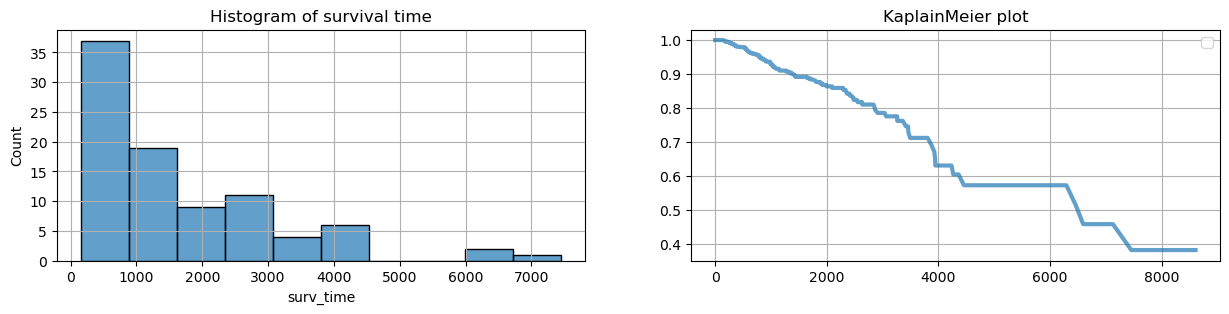

In [16]:
_, ax = plt.subplots(1, 2, figsize=(15, 3))

# Plot the hist plot
sns.histplot(data=surv_label_df[surv_label_df.surv_indicator == 1], x = 'surv_time', ax=ax[0], alpha=0.7)
ax[0].grid()
ax[0].set_title("Histogram of survival time")

# Plot the KaplainMeier plot
ax[1].grid()
ax[1].set_title("KaplainMeier plot")

kmf = KaplanMeierFitter()
kmf.fit(surv_times, surv_inds, label='kmf')
time = kmf.survival_function_.index.values
mean = kmf.survival_function_['kmf'].values
ax[1].plot(time, mean, linewidth=3, alpha=0.7)
ax[1].legend()
plt.show()

In [18]:
print("Censoring percentage {:.2f} %".format(100 * (1 - (sum(surv_inds) / len(surv_inds)))))

Censoring percentage 89.40 %


### Feature Analysis

In [21]:
feats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 840 entries, 14 to 1091
Columns: 20508 entries, years_to_birth to tAKR
dtypes: float64(20221), int64(282), object(5)
memory usage: 131.4+ MB


***Feature preprocessing***

In [24]:
# Split numerical and categorical features
numeric_feat_cols = feats.select_dtypes(include=[np.dtype('int64'), np.dtype('float64')]).columns.tolist()
cate_feat_cols = [col for col in feat_cols if col not in numeric_feat_cols]

In [25]:
# Remove categorical features with constant value 
cate_feat_cols_keep = []
for fname in cate_feat_cols:
    if len(np.unique(feats[fname].values)) > 1:
        cate_feat_cols_keep.append(fname)
cate_feat_cols = cate_feat_cols_keep



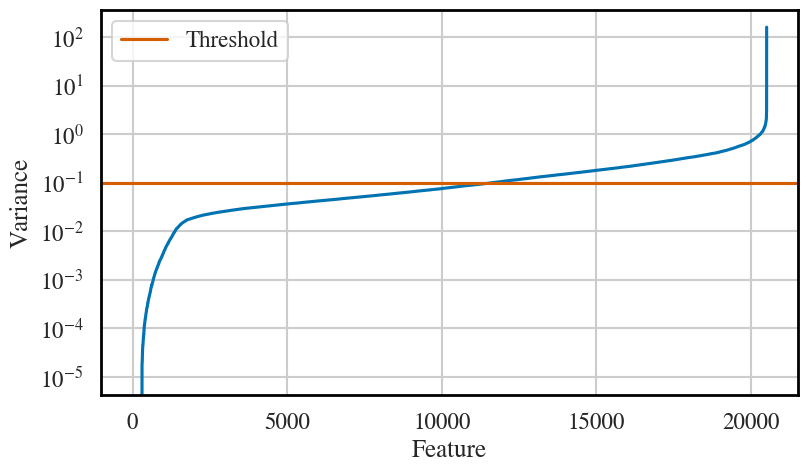

In [28]:
# Remove numerical features whose variance below a threshold
var_df = pd.DataFrame(feats[numeric_feat_cols].var().T, columns=['value'])
var_threshold = 0.1
numeric_feat_cols_keep = var_df[var_df.value > var_threshold].index.values.tolist()
numeric_feat_cols = numeric_feat_cols_keep
feat_cols = [col for col in feat_cols if col in numeric_feat_cols + cate_feat_cols]
feats = feats[feat_cols]

sns.set(style='whitegrid',font="STIXGeneral",context='talk',palette='colorblind')
_, ax = plt.subplots(figsize=(9, 5))
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_edgecolor('black')
var_df = var_df.sort_values(by='value')
var_df["idx"] = np.arange(var_df.shape[0])
g_results = sns.lineplot(data=var_df, x="idx", y="value")
g_results.set(yscale='log')
plt.axhline(y=var_threshold, c='r', label="Threshold") 
plt.xlabel("Feature")
plt.ylabel("Variance")
plt.legend()
plt.show()

***Feature pre-screening***

In [31]:
# Survival model to be explained
surv_label_structarray = []
for i in range(surv_label.shape[0]):
    surv_label_structarray.append((bool(surv_label[i, 1]), surv_label[i, 0]))

surv_label_structarray = np.rec.array(surv_label_structarray, dtype=[('indicator', bool), ('time', np.float32)])

# Encode categorical features
from sklearn.preprocessing import OneHotEncoder
feats_prep = feats[[col_name for col_name in numeric_feat_cols if col_name in kept_fixed_fnames]]
feats_prep[["surv_time", "surv_indicator"]] = surv_label_df[["surv_time", "surv_indicator"]].values
for feat_col in cate_feat_cols:
    enc = OneHotEncoder(drop='first')
    feat_new = enc.fit_transform(feats[feat_col].values.reshape((-1, 1))).toarray()
    feat_col_new = enc.get_feature_names_out([feat_col]).tolist()
    feats_prep[feat_col_new] = feat_new

from lifelines import CoxPHFitter
screen_stat_res = []
for fname in numeric_feat_cols:
    if fname not in kept_fixed_fnames:
        feat = feats_prep.copy(deep=True)
        feat[fname] = feats[fname].values
        cph = CoxPHFitter()
        cph.fit(feat, 'surv_time', 'surv_indicator')
        screen_stat_res.append([fname, cph.summary['-log2(p)'][fname]])

screen_stat_res_df = pd.DataFrame(data=screen_stat_res, columns=["Feature", "Nlogp"])
screen_stat_res_df = screen_stat_res_df.sort_values(by="Nlogp")
screen_stat_res_df["idx"] = np.arange(screen_stat_res_df.shape[0])

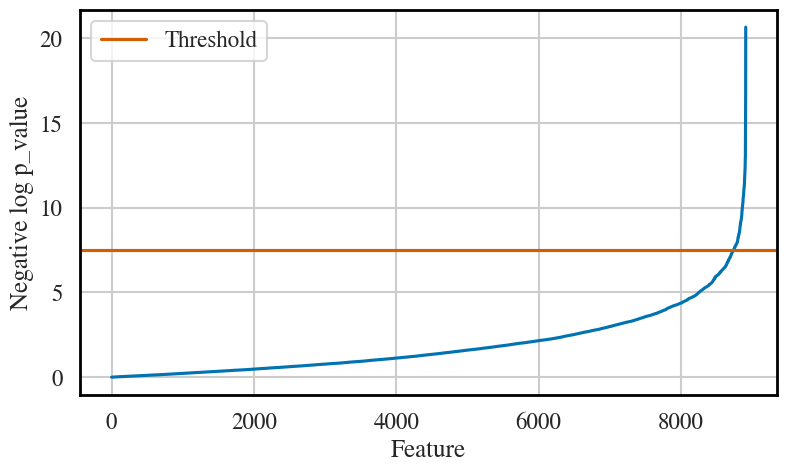

In [32]:
sns.set(style='whitegrid',font="STIXGeneral",context='talk',palette='colorblind')
_, ax = plt.subplots(figsize=(9, 5))
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_edgecolor('black')

sns.lineplot(data=screen_stat_res_df, x="idx", y="Nlogp")
sel_threshold = 7.5
plt.axhline(y=sel_threshold, c='r', label="Threshold") 
plt.xlabel("Feature")
plt.ylabel("Negative log p_value")
plt.legend()
plt.show()

In [33]:
numeric_expression_feat_cols = screen_stat_res_df[screen_stat_res_df.Nlogp.values > sel_threshold].Feature.values.tolist()
numeric_non_expression_feat_cols = [col_name for col_name in numeric_feat_cols if col_name in kept_fixed_fnames]
numeric_feat_cols = numeric_non_expression_feat_cols + numeric_expression_feat_cols
feat_cols = [col for col in feat_cols if col in numeric_feat_cols + cate_feat_cols]
feats = feats[feat_cols]

In [34]:
preprocessed_data = feats.copy(deep=True)
preprocessed_data[["surv_time", "surv_indicator"]] = surv_label_df[["surv_time", "surv_indicator"]].values
preprocessed_data.to_csv('preprocessed_data.csv', index=False)

In [44]:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 840 entries, 14 to 1091
Columns: 181 entries, years_to_birth to surv_indicator
dtypes: float64(177), object(4)
memory usage: 1.2+ MB
